# **Import Required Libraries**

In [1]:
import zipfile
from google.colab import drive
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

2025-10-16 12:22:36.316258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760617356.769019      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760617356.940701      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Preparation**

In [2]:
!gdown "https://drive.google.com/uc?id=1OcC1TwCdaOtliCaxPCtmruivX66cjNBF" -O ShopData.zip

import zipfile, os
with zipfile.ZipFile("ShopData.zip", 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working/ShopData")

data_dir = "/kaggle/working/ShopData/Shop DataSet"
shop_dir = os.path.join(data_dir, "shop lifters")
non_shop_dir = os.path.join(data_dir, "non shop lifters")

print(len(os.listdir(shop_dir)), "shop lifter videos")
print(len(os.listdir(non_shop_dir)), "non-shop lifter videos")

Downloading...
From (original): https://drive.google.com/uc?id=1OcC1TwCdaOtliCaxPCtmruivX66cjNBF
From (redirected): https://drive.google.com/uc?id=1OcC1TwCdaOtliCaxPCtmruivX66cjNBF&confirm=t&uuid=4d069009-5997-4aca-8ddb-44e1c5b36c17
To: /kaggle/working/ShopData.zip
100%|███████████████████████████████████████| 1.78G/1.78G [00:16<00:00, 110MB/s]
324 shop lifter videos
531 non-shop lifter videos


# **Data PreProcessing**

In [3]:
video_paths = []
labels = []

for file in os.listdir(shop_dir):
    video_paths.append(os.path.join(shop_dir, file))
    labels.append(1)

for file in os.listdir(non_shop_dir):
    video_paths.append(os.path.join(non_shop_dir, file))
    labels.append(0)

train_paths, val_paths, y_train, y_val = train_test_split(video_paths, labels, test_size=0.2, random_state=42, stratify=labels)

print("Train videos:", len(train_paths))
print("Validation videos:", len(val_paths))

Train videos: 684
Validation videos: 171


# **Augmentation & Data Generator**

In [4]:
import albumentations as A

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Rotate(limit=10, p=0.4),
    A.GaussianBlur(p=0.3),
    A.HueSaturationValue(p=0.3)
])

In [5]:
def video_generator(video_paths, labels, batch_size=4, n_frames=40, img_size=(128, 128), augment=False):
    while True:
        combined = list(zip(video_paths, labels))
        random.shuffle(combined)
        video_paths, labels = zip(*combined)

        for i in range(0, len(video_paths), batch_size):
            batch_paths = video_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            X_batch, Y_batch = [], []

            for path, label in zip(batch_paths, batch_labels):
                cap = cv2.VideoCapture(path)
                total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                step = max(total // n_frames, 1)
                frames = []

                for f in range(0, total, step):
                    if len(frames) >= n_frames:
                        break
                    ret, frame = cap.read()
                    if not ret:
                        break
                    frame = cv2.resize(frame, img_size)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                    if augment:
                        augmented = augmentor(image=frame)
                        frame = augmented["image"]

                    frame = frame / 255.0
                    frames.append(frame)

                cap.release()

                while len(frames) < n_frames:
                    frames.append(frames[-1])

                X_batch.append(np.array(frames))
                Y_batch.append(label)

            yield np.array(X_batch), np.array(Y_batch)

In [6]:
train_gen = video_generator(train_paths, y_train, batch_size=4, augment=True)
val_gen   = video_generator(val_paths, y_val, batch_size=4, augment=False)

# **Visualization**

In [7]:
def visualize_from_generator(generator, n_videos=3, n_frames_to_show=5):
    X_batch, Y_batch = next(generator)

    plt.figure(figsize=(15, n_videos * 3))

    for i in range(n_videos):
        idx = random.randint(0, len(X_batch) - 1)
        frames = X_batch[idx]
        label = "Shop Lifter" if Y_batch[idx] == 1 else "Non-Shop Lifter"

        frame_indices = np.linspace(0, len(frames)-1, n_frames_to_show, dtype=int)

        for j, f_idx in enumerate(frame_indices):
            plt.subplot(n_videos, n_frames_to_show, i * n_frames_to_show + j + 1)
            plt.imshow(np.clip(frames[f_idx], 0, 1))
            plt.axis("off")

            if j == n_frames_to_show // 2:
                plt.title(label, fontsize=12, color='red' if Y_batch[idx] == 1 else 'green')

    plt.tight_layout()
    plt.show()

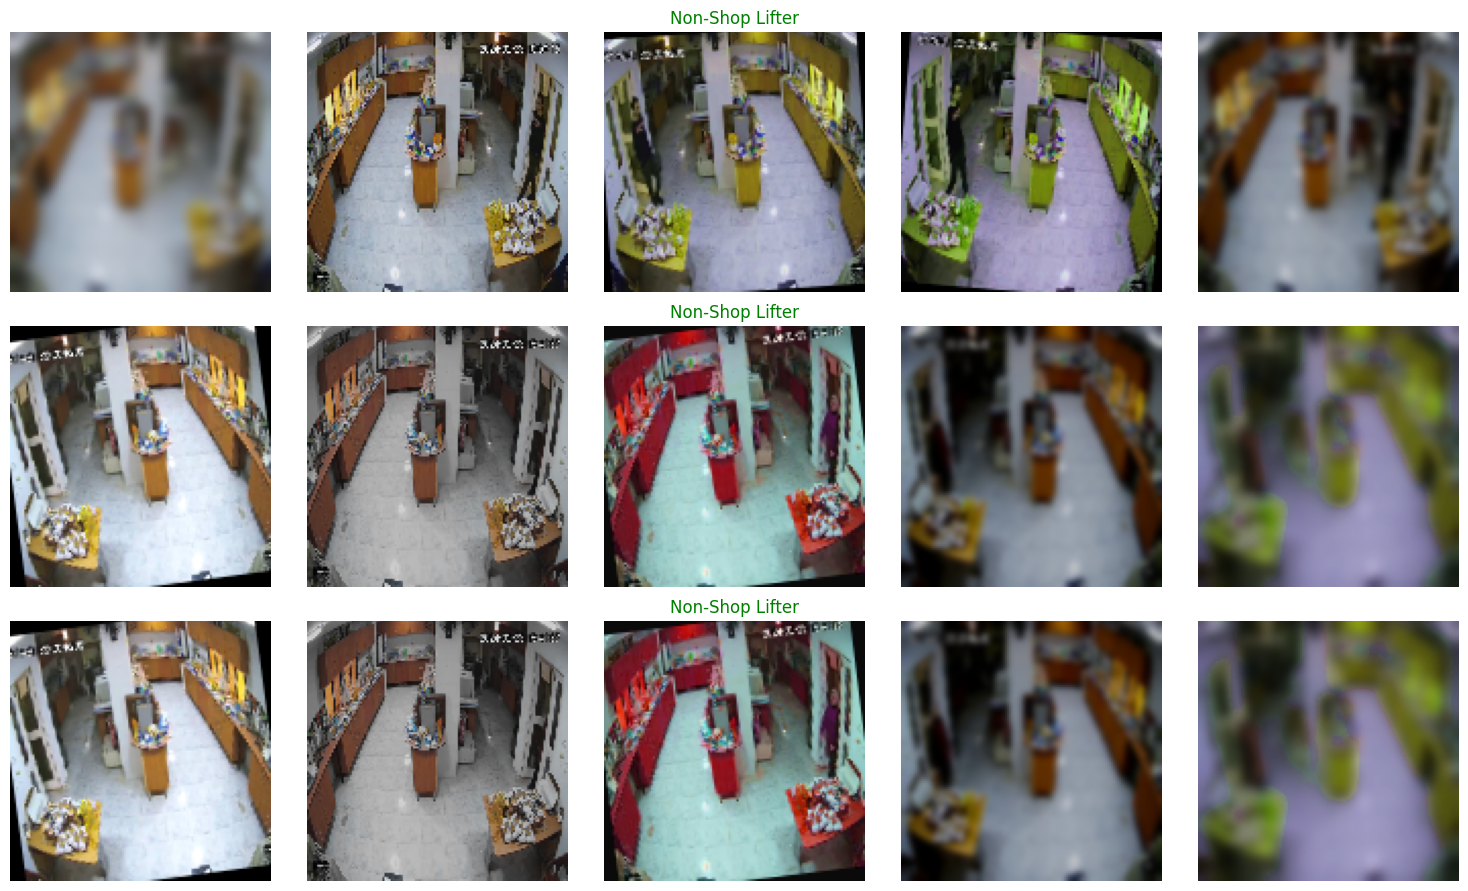

In [8]:
visualize_from_generator(train_gen, n_videos=3)

# **Modeling**

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

cnn_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

cnn_base.trainable = False

model = Sequential([
    TimeDistributed(cnn_base, input_shape=(40, 128, 128, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(128, return_sequences=False, dropout=0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model.summary()

I0000 00:00:1760617407.962942      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760617407.963721      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 40, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 40, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,987,713 (11.40 MB)

 Trainable params: 729,729 (2.78 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint('best_video_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
]

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    steps_per_epoch=len(train_paths) // 4,
    validation_steps=len(val_paths) // 4,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1760617620.804101     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


171/171 ━━━━━━━━━━━━━━━━━━━━ 339s 760ms/step - accuracy: 0.5590 - loss: 0.6832 - val_accuracy: 0.6607 - val_loss: 0.6379
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 68s 401ms/step - accuracy: 0.5952 - loss: 0.6692 - val_accuracy: 0.6429 - val_loss: 0.6242
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 69s 404ms/step - accuracy: 0.6426 - loss: 0.6508 - val_accuracy: 0.5893 - val_loss: 0.6461
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 68s 401ms/step - accuracy: 0.6540 - loss: 0.6248 - val_accuracy: 0.6707 - val_loss: 0.6155
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 67s 392ms/step - accuracy: 0.6894 - loss: 0.6078 - val_accuracy: 0.6108 - val_loss: 0.6301
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 62s 366ms/step - accuracy: 0.6632 - loss: 0.6202 - val_accuracy: 0.7485 - val_loss: 0.5420
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.7252 - loss: 0.5737 - val_accuracy: 0.7066 - val_loss: 0.5479
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 0.6749 - loss: 0.5852 - va

# **Evaluation**

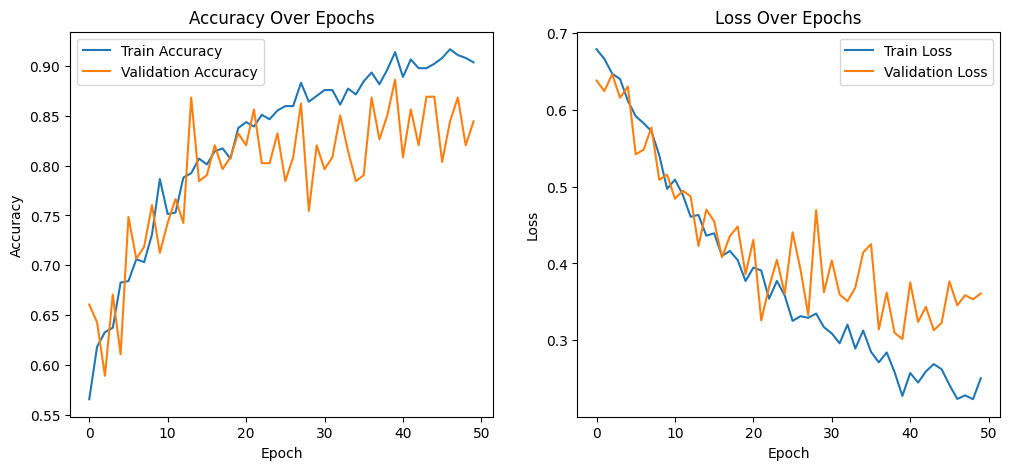

In [13]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()